In [1]:
# Disable logs in notebook
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Warnings
import warnings
warnings.filterwarnings("ignore")

# Import configurations
from src.config import *

# Clear any backend
tf.keras.backend.clear_session()

# Set seeds for reproducibility
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

In [2]:
# Plotting closing price and volume
df = pd.read_csv('data/unscaled_clean_data.csv', parse_dates=True, index_col='unix')

# Reload the saved scaled data
X_train = pd.read_csv('data/train/scaled_X_train.csv',
                      parse_dates=True, index_col='unix')
y_train = pd.read_csv('data/train/y_train.csv',
                      parse_dates=True, index_col='unix')
X_test = pd.read_csv('data/test/scaled_X_test.csv',
                     parse_dates=True, index_col='unix')
y_test = pd.read_csv('data/test/y_test.csv',
                     parse_dates=True, index_col='unix')
X_val = pd.read_csv('data/val/scaled_X_val.csv',
                    parse_dates=True, index_col='unix')
y_val = pd.read_csv('data/val/y_val.csv', parse_dates=True, index_col='unix')

# Calculate the weights for the imbalanced classes
y = pd.concat([y_train, y_val, y_test])
weights = cwts(y.values.flatten())

# Define the various feature selection methods
rf = RandomForestClassifier(n_jobs=-1, class_weight=weights)
boruta = BorutaPy(rf, n_estimators='auto', verbose=0, perc=90)
corr = RemoveCorPairwiseTransform()

pipe = Pipeline([('pairwisecorr', corr), ('boruta', boruta)])

X_train_pipe = pipe.fit_transform(X_train, y_train.values.ravel())
X_val_pipe = pipe.transform(X_val)
X_test_pipe = pipe.transform(X_test)

seqlen = 24
featurelen = X_train_pipe.shape[-1]

# Define the tensors
train_tensors = tf.keras.utils.timeseries_dataset_from_array(
    X_train_pipe, y_train.iloc[seqlen-1:], seqlen)
val_tensors = tf.keras.utils.timeseries_dataset_from_array(
    X_val_pipe, y_val.iloc[seqlen-1:], seqlen)
test_tensors = tf.keras.utils.timeseries_dataset_from_array(
    X_test_pipe, y_test.iloc[seqlen-1:], seqlen)

In [3]:
all_processed_features = np.concatenate([X_train_pipe, X_val_pipe,X_test_pipe])
all_y = pd.concat([y_train, y_val, y_test])

In [4]:
all_data_tensors = tf.keras.utils.timeseries_dataset_from_array(all_processed_features, all_y.iloc[seqlen-1:], seqlen)

In [6]:
final_model = tf.keras.saving.load_model('./models/final_models/0028.keras');

In [7]:
# Collect all the predictions
predictions = np.where(final_model.predict(all_data_tensors, verbose=0) > 0.5, 1, 0)

In [93]:
class BaseStrategyBacktest:
    def __init__(self, returns_df, predictions, val_start, test_start):
        self.returns_df = returns_df
        self.predictions = predictions
        self.val_start = val_start
        self.test_start = test_start
        self.results = self._assemble_df()
    
    def _assemble_df(self):
        results_df = self.returns_df.copy().to_frame()
        results_df.columns = ['return']
        results_df['long_only_hold'] = results_df.cumsum()
        results_df['predictions'] = self.predictions
        return results_df
        
    def process_signals(self):
        pass
    
    def plot(self):
        train_results = self.results[:self.val_start]
        val_results = self.results[self.val_start:self.test_start]
        test_results = self.results[self.test_start:]
        plt.plot(self.results['long_only_hold'], label='long_only_hold')
        plt.plot(train_results['strategy_return'], label='strategy_return_train_data')
        plt.plot(val_results['strategy_return'], c='y', label='strategy_return_val_data')
        plt.plot(test_results['strategy_return'], c='r', label='strategy_return_test_data')
        plt.ylabel('Return')
        plt.xlabel('Date')
        plt.legend()
        plt.show()
        return
    
class LongOnlyBacktest(BaseStrategyBacktest):
    def __init__(self, returns_df, predictions, val_start, test_start):
        super().__init__(returns_df, predictions, val_start, test_start)
        self._process_signals()
        
    def _process_signals(self):
        results_df = self.results.copy()
        # Initialise required columns as zeroes
        results_df['holding_begin_period'] = 0
        results_df['holding_end_period'] = 0
        results_df['strategy_return'] = 0
        # Apply the holdings
        results_df['holding_end_period'] = results_df.apply(self._set_holdings, axis=1)
        # Update holdings begin period
        results_df['holding_begin_period'] = results_df['holding_end_period'].shift(1)
        # Apply summation
        results_df['strategy_return'] = results_df.apply(self._sum_return, axis=1)
        results_df['strategy_return'] = results_df['strategy_return'].cumsum()
        # Have the first holding period be nil
        results_df['holding_begin_period'].iloc[0] = 0
        self.results = results_df
    
    def _set_holdings(self, row):
        # If the prediction is 1
        if row['predictions'] == 1:
            # If the holding is 1
            # Hold
            #If the holding is 0
            # Buy
            return 1
        # If the prediction is 0
        else:
            # If the holding is 1
            # Sell
            # If the holding is 0
            # Do nothing
            return 0
    
    def _sum_return(self, row):
        # if the state at beginning of period is 1 add return to running total
        if row['holding_begin_period'] == 1:
            return row['return']
        # If the state at beginning of period is 0 do not add return
        else:
            return 0

In [94]:
val_start = X_val.iloc[0].name
test_start = X_test.iloc[0].name

In [95]:
long_only_strategy = LongOnlyBacktest(df['LOGRET_1'].iloc[seqlen-1:], predictions, val_start, test_start)

In [96]:
long_only_strategy.results

,return,long_only_hold,predictions,holding_begin_period,holding_end_period,strategy_return
unix,,,,,,
2018-02-27 08:00:00+00:00,0.002905,0.002905,0,0.0,0,0.000000
2018-02-27 09:00:00+00:00,-0.002501,0.000404,0,0.0,0,0.000000
2018-02-27 10:00:00+00:00,-0.014487,-0.014083,1,0.0,1,0.000000
2018-02-27 11:00:00+00:00,0.005351,-0.008732,0,1.0,0,0.005351
2018-02-27 12:00:00+00:00,-0.000102,-0.008834,0,0.0,0,0.005351
...,...,...,...,...,...,...
2023-12-11 18:00:00+00:00,-0.006814,0.898652,1,0.0,1,73.632239
2023-12-11 19:00:00+00:00,-0.001257,0.897395,1,1.0,1,73.630982
2023-12-11 20:00:00+00:00,0.005473,0.902867,1,1.0,1,73.636455


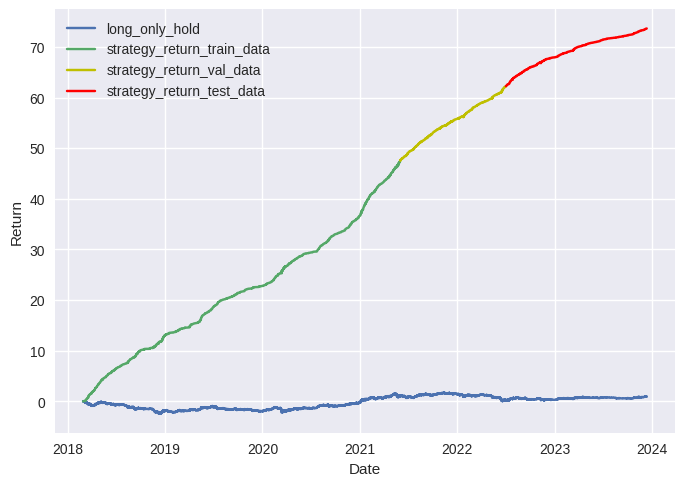

In [97]:
long_only_strategy.plot()